# AWS Comprehend Sentiment Analysis Using Python

This notebook shows how to use boto3 Amazon API to use Amazon Comprehend for real time analysis as well as scheduling analysis jobs.
1. For boto3 to work you need to create an IAM User, receive `aws_access_key_id` and `aws_secret_access_key` and configure your credentials using AWS Command Line Interface (AWS CLI)
2. Cost. If you are using free AWS tier, you can analyze 50K units a month free.  Every unit is 100 characters. In my example, every tweet is ~2 units. In the scheduled job I am analyzing 10K tweets at once, so the free tier runs out pretty fast, and then it's \$1 per 10K. Be sure to check pricing before you proceed. https://aws.amazon.com/comprehend/pricing/
3. Reference. Boto3 S3: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html  Boto3 Comprehend: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html

In [1]:
pip install boto3 langdetect textblob

     |████████████████████████████████| 131 kB 7.6 MB/s 
     |████████████████████████████████| 981 kB 44.0 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 8.4 MB 27.3 MB/s 
     |████████████████████████████████| 138 kB 76.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=9af3997db25923f463e1ab24b83d83bc7cc7018701717bba967edc6c3c2f74b3
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urll

In [2]:
!pip install emoji --upgrade

     |████████████████████████████████| 170 kB 7.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=a20cea4e5063bec137387c0b447e44418c15edb64312610a20eca1db1ab67dc8
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [138]:
import configparser
import os

from langdetect import detect

import boto3

import pandas as pd
import json
import tarfile  # for unzipping files

from emoji import demojize

from platform import python_version

In [4]:
print(python_version())

3.7.12


In [5]:
pd.set_option('display.max_colwidth', None)

In [77]:
# https://github.com/chonchonj23/Scrapped_Comments_YouTube_Covid/blob/master/YouTube_comments.xlsx

df_excel = pd.read_excel('YouTube_comments.xlsx', index_col=0)  

In [139]:
df_excel.count()

Search_Keywords    2917
urls               2917
Title              2910
Comments           2909
dtype: int64

In [78]:
df_excel.head()

,Search_Keywords,urls,Title,Comments
0,MACAU COVID,https://www.youtube.com/watch?v=cKFQ3Tq1E1I,NaN,NaN
1,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?."
2,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,Still beautiful.
3,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do."
4,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism - the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. - all will be less crowded. On the other hand, the on-line business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeople-to-people contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days."


In [10]:
df_k = df_excel[df_excel['Comments'].notnull()]
df = df_k.rename({'Comments': 'Youtube Comments'}, axis=1)
df['Youtube Comments'] = df['Youtube Comments'].apply(lambda x: demojize(x))

In [83]:
# df = df.reset_index()

In [84]:
df.head(5)

,index,Search_Keywords,urls,Title,Youtube Comments,language
0,1,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?.",True
1,2,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,Still beautiful.,True
2,3,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do.",True
3,4,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. all will be less crowded. On the other hand, the online business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeopletopeople contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days.",True
4,5,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,I don't see why it is called a ghost town,True


## Another data source

In [5]:
# Comments extracted from Youtube videos via Youtube API 
# link_to_data = "https://raw.githubusercontent.com/chonchonj23/Comments-data-from-Youtube-videos-related-to-COVID-19/main/Youtube_Comments_Combined_16Dec.csv"

link_to_data = "https://raw.githubusercontent.com/chonchonj23/COVID-comments-in-Youtube/master/Youtube_COVID_Comments_16Dec_All_v2.csv"

df = pd.read_csv(link_to_data, header = 0, dtype = 'str', encoding = 'utf-8', lineterminator='\n') 

## Continued

In [11]:
df.count()

Search_Keywords     2909
urls                2909
Title               2909
Youtube Comments    2909
dtype: int64

In [12]:
# to identify English Comments

def isEnglish(s):
  try:
      # s.isalpha()
      # return s.isalpha()
      s.isascii()
      return s.isascii()

  except Exception:
      return False

In [41]:
# isEnglish("’")

In [ ]:
# isEnglish("I thought they were “vaccinated” when will y’all wake up. What’s the point of the vaccination if you’re just going to quarantine everyone")

In [85]:
df['Youtube Comments'] = df['Youtube Comments'].str.strip()

df['language'] = df['Youtube Comments'].replace("’", "", regex=True)\
.replace("1:1", "", regex=True).replace("…", "", regex=True).replace("”", "", regex=True)\
.replace("’", "", regex=True).replace("“", "", regex=True)\
.replace("\n", ";", regex=True).replace("\t", ";", regex=True).replace("\r", ";", regex=True).replace("\v", ";", regex=True)\
.replace("-", "", regex=True).replace("      ", "", regex=True)\
.apply(lambda x: isEnglish(x))

In [86]:
# .replace("/n", ";", regex=True).replace("/t", ";", regex=True).replace("/r", ";", regex=True).replace("/v", ";", regex=True)\

df['Youtube Comments'] = df['Youtube Comments'].replace("’", "", regex=True)\
.replace("1:1", "", regex=True).replace("…", "", regex=True).replace("”", "", regex=True)\
.replace("’", "", regex=True).replace("“", "", regex=True)\
.replace("\n", ";", regex=True).replace("\t", ";", regex=True).replace("\r", ";", regex=True).replace("\v", ";", regex=True)\
.replace("-", "", regex=True).replace("      ", "", regex=True)

In [87]:
df.head(5)

,index,Search_Keywords,urls,Title,Youtube Comments,language
0,1,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?.",True
1,2,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,Still beautiful.,True
2,3,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do.",True
3,4,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. all will be less crowded. On the other hand, the online business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeopletopeople contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days.",True
4,5,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,I don't see why it is called a ghost town,True


In [16]:
df[df['Youtube Comments'].str.contains("\n")]

,Search_Keywords,urls,Title,Youtube Comments,language


In [233]:
df[df['Youtube Comments'].str.contains("\r")]

,Search_Keywords,urls,Title,Youtube Comments,language


In [234]:
df[df['Youtube Comments'].str.contains("\v")]

,Search_Keywords,urls,Title,Youtube Comments,language


In [44]:
# df[300000:300005]

In [88]:
df[df['language']==True].count()

index               2784
Search_Keywords     2784
urls                2784
Title               2784
Youtube Comments    2784
language            2784
dtype: int64

In [89]:
df[df['language']==False].count()

index               125
Search_Keywords     125
urls                125
Title               125
Youtube Comments    125
language            125
dtype: int64

In [90]:
df[df['language']==False].tail(4)

,index,Search_Keywords,urls,Title,Youtube Comments,language
2830,2836,MACAU COVID CASINO,https://www.youtube.com/watch?v=ayasTHA3MQo,Macau police arrest Suncity casino junket boss in crackdown on online gambling,ถึงเวลาปฎิวัติอุตสาหกรรมการพนัน;ในหม่าเก๊า ที่ส่งผลเสียให้ระบบการเงิน ทั้งภายในประเทศ และระหว่างประเทศ การฟอกเงิน ด้วยระบบดิจิทัลเสมือนจริง โดยอิงอาศัยรูปแบบของเกมส์ และการพนันต่างๆ มันผิดกฎหมายการเงินอย่างร้ายแรง;ส่งผลกระทบต่อระบบสากล;องค์กรตำรวจได้ผู้บังคับบัญชามีศักยภาพ ทำงานตรงเป้าหมายมากๆค่ะ,False
2834,2840,MACAU COVID CASINO,https://www.youtube.com/watch?v=ayasTHA3MQo,Macau police arrest Suncity casino junket boss in crackdown on online gambling,"Firmen die Werbung bezahlen bei YouTube müssen verzweifelt sein , jedes versuch etwas zu kuchen auf YouTube wird automatisch mit 20 bis 30 werbe versuche gekoppelt. Aber von Firmen die meine Privatsphäre ausrauben mit Agresive Werbung werbe ich niemals einkaufen , NIEMALS .",False
2859,2865,MACAU COVID CASINO,https://www.youtube.com/watch?v=ayasTHA3MQo,Macau police arrest Suncity casino junket boss in crackdown on online gambling,小賭怡情大賭家破人亡?病態賭徒中國大陸有不少偷渡都要來賭博?澳門經濟依賴賭博愈病愈深?Little gamble joyful big gamble lost family dead relative ? Sick behaviour gambler full of Mainland China wanted to gamble needed illegal immigration ?Macau economic reliable with gamble industry more illness more deeper ?,False
2876,2882,MACAU COVID CASINO,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,#不能不明白 https://www.blogdog.in/post/thingstodoinhongkongamidcoronavirusfear,False


In [91]:
df_keep = df[df['language']==True]

In [92]:
df_keep.count()

index               2784
Search_Keywords     2784
urls                2784
Title               2784
Youtube Comments    2784
language            2784
dtype: int64

In [93]:
df_keep = df_keep.reset_index()

In [94]:
df_keep.head()

,level_0,index,Search_Keywords,urls,Title,Youtube Comments,language
0,0,1,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?.",True
1,1,2,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,Still beautiful.,True
2,2,3,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do.",True
3,3,4,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. all will be less crowded. On the other hand, the online business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeopletopeople contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days.",True
4,4,5,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,I don't see why it is called a ghost town,True


In [21]:
# export data for uploading to S3 later

local_file_name = 'youtube_covid_comments_only2.csv'

df_output = df_keep['Youtube Comments']

df_output.to_csv(local_file_name, encoding = 'utf-8', index = False, header = False)

In [22]:
# check volume

# df_chk = pd.read_csv(local_file_name, header = 0, dtype = 'str', encoding = 'utf-8', lineterminator='\n') 
df_chk = pd.read_csv(local_file_name, header = None, names = ['Youtube Comments'], 
                     dtype = 'str', encoding = 'utf-8', lineterminator='\n') 

In [23]:
df_chk.count()

Youtube Comments    2784
dtype: int64

In [24]:
df_chk[df_chk['Youtube Comments'].str.contains("\r")]

,Youtube Comments


In [25]:
df_chk[df_chk['Youtube Comments'].str.contains("\n")]

,Youtube Comments


In [26]:
df_chk[df_chk['Youtube Comments'].str.contains("\v")]

,Youtube Comments


In [251]:
df_chk.head()

,Youtube Comments
0,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?."
1,Still beautiful.
2,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do."
3,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. all will be less crowded. On the other hand, the online business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeopletopeople contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days."
4,I don't see why it is called a ghost town


## Real Time Single Record Processing

Using this type of processing you can analyze one piece of text of up to 5K bytes long.

In [32]:
# Select a single tweet
# text = df.loc[1].item()

text = df_keep['Youtube Comments'].iloc[2500]
print(text)

I am a Macau citizen and dead ass they give all Macau citizen 10000 dollars (in USD it is about 1.6 k dollars) every year and the best thing is every year they up it by 100 USD


In [33]:
config = configparser.ConfigParser()
config.read_file(open('credentials_Chon_HKDL.cfg'))
# config.read_file(open('credentials.cfg'))
# config.read_file(open('your_aws_credentials.cfg'))

os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']

In [34]:
# ad hoc check
# os.environ["AWS_ACCESS_KEY_ID"]

In [35]:
#initialize Comprehend module
comprehend = boto3.client(service_name='comprehend', 
                          region_name='us-west-2',  
                          aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
                          aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"] )

In [36]:
# Run sentiment analysis
sentiment_output = comprehend.detect_sentiment(Text=text, LanguageCode='en')
# Output
sentiment_output

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '156',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 17 Dec 2021 15:08:04 GMT',
   'x-amzn-requestid': 'c48d172c-e589-449a-8b0c-6e607e8ef6dd'},
  'HTTPStatusCode': 200,
  'RequestId': 'c48d172c-e589-449a-8b0c-6e607e8ef6dd',
  'RetryAttempts': 0},
 'Sentiment': 'MIXED',
 'SentimentScore': {'Mixed': 0.4026598334312439,
  'Negative': 0.274492472410202,
  'Neutral': 0.13114459812641144,
  'Positive': 0.1917031705379486}}

In [37]:
# check orginal tweet
print(text)

I am a Macau citizen and dead ass they give all Macau citizen 10000 dollars (in USD it is about 1.6 k dollars) every year and the best thing is every year they up it by 100 USD


In [ ]:
# check Dictionary elements in sentiment_batch
keys_list = list(sentiment_output)

for i in range(len(sentiment_output)):
  a_key = keys_list[i]
  print(a_key)

Sentiment
SentimentScore
ResponseMetadata


In [147]:
#Get Sentiment prediction
sentiment_output['Sentiment']

'MIXED'

In [148]:
#Get Sentiment Confidence Score
sentiment_output['SentimentScore']

{'Mixed': 0.4026598334312439,
 'Negative': 0.274492472410202,
 'Neutral': 0.13114459812641144,
 'Positive': 0.1917031705379486}

## Real-Time Batch Processing

Up to 25 documents of up to 5,000 bytes each, submitted in a list.

In [90]:
# Create a batch
# text_list = list(df.walmart_tweets[75:100])
text_list = list(df_keep['Youtube Comments'][2000:2025])

#Run a sentiment batch
sentiment_batch = comprehend.batch_detect_sentiment(TextList=text_list,
                                                    LanguageCode='en')

In [91]:
# print the first 10 documents in the batch
for i in range(5):
  print(text_list[i])

Excuse me will you report/watch indian protests against/versus CAA LAW (5 FEB,INDIA)   Request to Arirang news to cover indian conditions/situations by CAA LAW
  PUBLIC IS DISCOMFORT
Bring people to home and leave Chinese people there because they cause the problem by eating stupid staff. :pouting_face: Omg !!!
I never knew that Chinese like to Gamble !
People are dying and u guys r worried for the casino. Cumon.....
Peasant wet market bat seller holed up somewhere in China thinking, "What the Hell have I done?"


In [92]:
len(sentiment_batch)

3

In [209]:
# check Dictionary elements in sentiment_batch
keys_list = list(sentiment_batch)

for i in range(len(sentiment_batch)):
  a_key = keys_list[i]
  print(a_key)

ResultList
ErrorList
ResponseMetadata


In [94]:
type(sentiment_batch['ResultList'])

list

In [93]:
len(sentiment_batch['ResultList'])

25

In [217]:
len(sentiment_batch['ErrorList'])

0

In [218]:
len(sentiment_batch['ResponseMetadata'])

4

In [95]:
print(text_list[4])

Peasant wet market bat seller holed up somewhere in China thinking, "What the Hell have I done?"


In [96]:
# Check the 5th document in batch submitted
sentiment_batch['ResultList'][4]

{'Index': 4,
 'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Mixed': 0.0003691824385896325,
  'Negative': 0.8612551689147949,
  'Neutral': 0.13579010963439941,
  'Positive': 0.002585510490462184}}

Parse the results into a dataframe

In [136]:
def parse_sentiment_batch(data):
    df = pd.DataFrame([item['SentimentScore'] for item in data['ResultList']])
    df['Sentiment'] = [item.get('Sentiment') for item in data['ResultList']]
    df['Index'] = [item.get('Index') for item in data['ResultList']]
    df.set_index('Index', inplace = True)
    
    return(df)

In [137]:
parse_sentiment_batch(sentiment_batch).head()

NameError: ignored

In [41]:
# df.walmart_tweets[78]

In [99]:
batch_results = parse_sentiment_batch(sentiment_batch)

In [100]:
batch_results['Text'] = text_list

In [101]:
batch_results.head()

,Positive,Negative,Neutral,Mixed,Sentiment,Text
Index,,,,,,
0,0.009532,0.162401,0.825694,0.002373,NEUTRAL,"Excuse me will you report/watch indian protests against/versus CAA LAW (5 FEB,INDIA) Request to Arirang news to cover indian conditions/situations by CAA LAW\n PUBLIC IS DISCOMFORT"
1,0.005708,0.912839,0.068042,0.013412,NEGATIVE,Bring people to home and leave Chinese people there because they cause the problem by eating stupid staff. :pouting_face: Omg !!!
2,0.204757,0.183340,0.609889,0.002014,NEUTRAL,I never knew that Chinese like to Gamble !
3,0.005097,0.819282,0.151375,0.024246,NEGATIVE,People are dying and u guys r worried for the casino. Cumon.....
4,0.002586,0.861255,0.135790,0.000369,NEGATIVE,"Peasant wet market bat seller holed up somewhere in China thinking, ""What the Hell have I done?"""


## Asynchronous Processing

I highly recommend that you run at least one Comprehend job from the point and click interface, especially, if you are new to AWS. This way you can create a data access role (aka `data_access_role_arn`), and then you can simply copy the role name from the job description. 

You will need to create your S3 bucket through the web interface or through BOTO3 API.

Note that I use different folders `s3://comprehend-api/input-data` and `s3://comprehend-api/results` for input data and results output. This way, your results are not going to get confused for inputs if you were to analyze all files in the folder.

#### Upload the data to S3

In [29]:
# define bucket varialbes
local_file_name = 'youtube_covid_comments_only2.csv'

# bucket_name = 'chon-hkdl-demo'
bucket_name = 'chon-hkdl-private'

aws_file_name = 'input-data-17Dec/scrapped_youtube_covid_comments_only2.csv'

In [253]:
# Upload file to specific location (only if data is not already there)

s3 = boto3.client('s3')
s3.upload_file(local_file_name, bucket_name, aws_file_name)

#### Configure Sentiment Detection Job

In [255]:
# Set these values before running the program
# input_s3_url = 's3://YOUR_BUCKET_NAME/YOUR_BUCKET_FOLDER/FILE_NAME.csv' #folder, file or prefix
input_s3_url = "s3://chon-hkdl-private/input-data-17Dec/scrapped_youtube_covid_comments_only2.csv"

input_doc_format = 'ONE_DOC_PER_LINE'

output_s3_url = 's3://chon-hkdl-private/results_17Dec_v6'

# data_access_role_arn = "arn:aws:iam::YOUR_ACCOUNT_NUMBER:role/service-role/YOUR_SERVICE_ROLE"
data_access_role_arn = "arn:aws:iam::286289698935:role/ComprehendS3Role2"


# Set up job configuration
input_data_config = {'S3Uri': input_s3_url, 'InputFormat': input_doc_format}
output_data_config = {'S3Uri': output_s3_url}

#### Run the job

In [256]:
# Start the client - Chon
# comprehend = boto3.client('comprehend')

comprehend = boto3.client(service_name='comprehend', 
                          region_name='us-west-2',
                          aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
                          aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"] )


# Begin a job to detect the topics in the document collection
start_job_sentiment = comprehend.start_sentiment_detection_job(
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    DataAccessRoleArn=data_access_role_arn,
    LanguageCode='en',
    JobName='Youtube_COVID_Comments')
job_id = start_job_sentiment['JobId']
print(f'Your Sentiment Detection JobID is: {job_id}')

Your Sentiment Detection JobID is: b841dd42927179a57826e4fbbf6abca0


Your job runs asynchronously. **This may take several minutes to run.**
When the status turns to COMPLETED, you can retrieve the results.

In [259]:
# Retrieve information about the job - the job may take a while to run - Chon
describe_result = comprehend.describe_sentiment_detection_job(JobId=job_id)
job_status = describe_result['SentimentDetectionJobProperties']['JobStatus']
print(f'Job Status: {job_status}')
if job_status == 'FAILED':
    print(f'Reason: {describe_result["SentimentDetectionJobProperties"]["Message"]}')

Job Status: COMPLETED


In [30]:
# Use job_id from previous run
job_id = 'b841dd42927179a57826e4fbbf6abca0'

#### Download the Results

In [38]:
#  The results are located here
results_S3Url = comprehend.describe_sentiment_detection_job(
    JobId=job_id)['SentimentDetectionJobProperties']['OutputDataConfig']['S3Uri']

# Your Output S3 Url
results_S3Url

's3://chon-hkdl-private/results_17Dec_v6/286289698935-SENTIMENT-b841dd42927179a57826e4fbbf6abca0/output/output.tar.gz'

If you don't know where your results are, get a listing of your bucket

In [39]:
# List all files and folders in the bucket
def s3_bucket_list_obj(bucket):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket)
    for obj in bucket.objects.all():
        print(obj.key)

In [40]:
# List all files
s3_bucket_list_obj(bucket_name)

input-data-17Dec/scrapped_youtube_covid_comments.csv
input-data-17Dec/scrapped_youtube_covid_comments_only.csv
input-data-17Dec/scrapped_youtube_covid_comments_only2.csv
input-data-17Dec/scrapped_youtube_covid_comments_v2.csv
results_17Dec_v3/.write_access_check_file.temp
results_17Dec_v3/286289698935-SENTIMENT-1e37037b05665f38ed3f7b873414f0f1/output/output.tar.gz
results_17Dec_v4/.write_access_check_file.temp
results_17Dec_v4/286289698935-SENTIMENT-34b2e20874fa47d335a407df24662f03/output/output.tar.gz
results_17Dec_v5/.write_access_check_file.temp
results_17Dec_v5/286289698935-SENTIMENT-5cba097c08e856531d9b75144c8867d2/output/output.tar.gz
results_17Dec_v6/.write_access_check_file.temp
results_17Dec_v6/286289698935-SENTIMENT-b841dd42927179a57826e4fbbf6abca0/output/output.tar.gz


Download the results, which in our case, to Colab

In [41]:
print(results_S3Url)

s3://chon-hkdl-private/results_17Dec_v6/286289698935-SENTIMENT-b841dd42927179a57826e4fbbf6abca0/output/output.tar.gz


In [42]:
# Give your local results file a name; after download, there should be a file called "sentiment.tar.gz" in Colab
results_name = 'sentiment'

# local_results_filename = 'Comprehend/outputs/' + results_name + '.tar.gz'
local_results_filename = results_name + '.tar.gz'

s3_name = 's3://' + bucket_name + '/'
results_aws_filename = results_S3Url.replace(s3_name, '')

# Download results
s3 = boto3.client('s3')
s3.download_file(bucket_name,
                 results_aws_filename, 
                 local_results_filename)

In [43]:
print(results_aws_filename)

results_17Dec_v6/286289698935-SENTIMENT-b841dd42927179a57826e4fbbf6abca0/output/output.tar.gz


#### Process the results

In [44]:
# Unzip the file 
# Output filename would just be 'output' without filename extension
def extract_targz(targz_file, output_path = ''):
    if targz_file.endswith("tar.gz"):
        tar = tarfile.open(targz_file, "r:gz")
        tar.extractall(path = output_path)
        tar.close()
    elif targz_file.endswith("tar"):
        tar = tarfile.open(targz_file, "r:")
        tar.extractall(path = output_path)
        tar.close()

In [45]:
# creates a temp file is called 'output'
results_name = 'sentiment'
# local_results_filename = 'Comprehend/outputs/' + results_name + '.tar.gz'
local_results_filename =  results_name + '.tar.gz'

output_path = 'Comprehend/outputs/extracted'  #subfolders Comprehend/outputs/extracted will be created in Colab in our case
# output_path = 'Comprehend/outputs/extracted_2'
extract_targz(local_results_filename, output_path)

Read the results

In [46]:
# Read JSON into a list of dictionary   
input_file = output_path + '/output'
results = [json.loads(line) for line in open(input_file, 'r')]
print('Number of records in the output:',len(results))

Number of records in the output: 2784


In [47]:
df_keep.count()

Search_Keywords     2784
urls                2784
Title               2784
Youtube Comments    2784
language            2784
dtype: int64

In [140]:
type(results)

list

In [141]:
type(results[99])

dict

In [49]:
len(results)

2784

This is how the output looks like. Note that often the records are not in the same order that they were sent in.

In [48]:
results[15]

{'File': 'scrapped_youtube_covid_comments_only2.csv',
 'Line': 45,
 'Sentiment': 'NEUTRAL',
 'SentimentScore': {'Mixed': 0.0006715249037370086,
  'Negative': 0.043208785355091095,
  'Neutral': 0.8975278735160828,
  'Positive': 0.05859178677201271}}

In [50]:
# This function parses sentiment data into a dataframe
# def parse_sentiment(data):
#     df = pd.DataFrame([item['SentimentScore'] for item in data])
#     df['File'] = [item.get('File') for item in data]
#     df['Sentiment'] = [item.get('Sentiment') for item in data]
#     df['Line'] = [item.get('Line') for item in data]
#     df.set_index('Line', inplace = True)
    
#     return(df)

In [142]:
def parse_sentiment(data):
    df = pd.DataFrame([item['SentimentScore'] for item in data])
    df['File'] = [item.get('File') for item in data]
    df['Sentiment'] = [item.get('Sentiment') for item in data]
    df['Line'] = [item.get('Line') for item in data]
    df.set_index('Line', inplace = True)
    
    column_names = [ 'Positive', 'Negative', 'Neutral', 'Mixed', 'Sentiment', 'File' ]
    df = df.reindex(columns=column_names)

    return(df)

In [143]:
# convert Results into Dataframe
# Let's sort and index the dataframe by line
sentiment_results = parse_sentiment(results).sort_index()

In [96]:
sentiment_results.head(6)

,Positive,Negative,Neutral,Mixed,Sentiment,File
Line,,,,,,
0,0.037343,0.158000,0.130153,0.674504,MIXED,scrapped_youtube_covid_comments_only2.csv
1,0.995447,0.000157,0.001355,0.003040,POSITIVE,scrapped_youtube_covid_comments_only2.csv
2,0.038441,0.053885,0.907608,0.000065,NEUTRAL,scrapped_youtube_covid_comments_only2.csv
3,0.059411,0.036693,0.161282,0.742614,MIXED,scrapped_youtube_covid_comments_only2.csv
4,0.013596,0.478283,0.456378,0.051742,NEGATIVE,scrapped_youtube_covid_comments_only2.csv
5,0.640076,0.020303,0.035802,0.303819,POSITIVE,scrapped_youtube_covid_comments_only2.csv


In [97]:
sentiment_results.iloc[500:506]

,Positive,Negative,Neutral,Mixed,Sentiment,File
Line,,,,,,
500,0.136216,0.015026,0.848630,0.000128,NEUTRAL,scrapped_youtube_covid_comments_only2.csv
501,0.045969,0.171399,0.030857,0.751775,MIXED,scrapped_youtube_covid_comments_only2.csv
502,0.982561,0.004685,0.012517,0.000238,POSITIVE,scrapped_youtube_covid_comments_only2.csv
503,0.863152,0.105813,0.015464,0.015571,POSITIVE,scrapped_youtube_covid_comments_only2.csv
504,0.663567,0.059080,0.233360,0.043993,POSITIVE,scrapped_youtube_covid_comments_only2.csv
505,0.983667,0.000913,0.014668,0.000752,POSITIVE,scrapped_youtube_covid_comments_only2.csv


In [98]:
df_keep.head()

,level_0,index,Search_Keywords,urls,Title,Youtube Comments,language
0,0,1,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?.",True
1,1,2,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,Still beautiful.,True
2,2,3,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do.",True
3,3,4,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. all will be less crowded. On the other hand, the online business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeopletopeople contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days.",True
4,4,5,MACAU COVID,https://www.youtube.com/watch?v=8hxxdfprEsY,Macau turns into ghost town amid Wuhan virus cases,I don't see why it is called a ghost town,True


#### Results Validation

Let's take a look at a record and validate that the results were similar (they won't be exactly the same), and that we sorted the dataframe correctly.

In [99]:
record_no = 999
print('TWEET TEXT:\n', df_keep['Youtube Comments'].iloc[record_no])

TWEET TEXT:
 The reason I will visit Macao will be because of the colonial city, I dont care about casino's!


In [100]:
# boto3 reference
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html

nl = "\n"
record_no = 100
# Tweet text
# print('TWEET TEXT:\n', df.loc[record_no].item())
print('TWEET TEXT:\n', df_keep['Youtube Comments'].iloc[record_no])

# Real Time Results
print('\nREAL TIME RESULTS of Sentiment Scores:') 
# print(comprehend.detect_sentiment(Text=df.loc[record_no].item(), LanguageCode='en')['SentimentScore'])
# print(f"{comprehend.detect_sentiment(Text=df.loc[record_no].item(), LanguageCode='en')['SentimentScore']}"
#       f"{nl}")

print(f"{comprehend.detect_sentiment(Text=df_keep['Youtube Comments'].iloc[record_no], LanguageCode='en')['SentimentScore']}"
      f"{nl}")


print('REAL TIME RESULTS of Sentiment Prediction:') 
# print(f"{comprehend.detect_sentiment(Text=df.loc[record_no].item(), LanguageCode='en')['Sentiment']}")
print(f"{comprehend.detect_sentiment(Text=df_keep['Youtube Comments'].iloc[record_no], LanguageCode='en')['Sentiment']}")

# Job Resutls
print('\nASYNCHRONOUS RESULTS:')
print(sentiment_results.loc[record_no])

TWEET TEXT:
 Great video I just did a video on how we are being misled

REAL TIME RESULTS of Sentiment Scores:
{'Positive': 0.23583178222179413, 'Negative': 0.030124951153993607, 'Neutral': 0.020934006199240685, 'Mixed': 0.7131092548370361}

REAL TIME RESULTS of Sentiment Prediction:
MIXED

ASYNCHRONOUS RESULTS:
Positive                                      0.235832
Negative                                      0.030125
Neutral                                       0.020934
Mixed                                         0.713109
Sentiment                                        MIXED
File         scrapped_youtube_covid_comments_only2.csv
Name: 100, dtype: object


#### Save the results file

In [112]:
output_name = 'Comprehend/outputs/sentiment_results_Youtube_Comments_Scrapped.xlsx'
# sentiment_results['Text'] = df.walmart_tweets

sentiment_results['Text'] = df_keep['Youtube Comments']

sentiment_results['urls'] = df_keep['urls']

In [109]:
sentiment_results.to_excel(output_name, encoding = 'utf-8')

In [102]:
df_keep['Youtube Comments'].iloc[0]

'I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?.'

In [105]:
# df_keep.head()

In [104]:
sentiment_results.head()

,Positive,Negative,Neutral,Mixed,Sentiment,File,Text
Line,,,,,,,
0,0.037343,0.158000,0.130153,0.674504,MIXED,scrapped_youtube_covid_comments_only2.csv,"I guess this is a good sign isnt it?, at least it shows people have safety awareness and dont venture around while there is risk of infection. No praise for the local population?."
1,0.995447,0.000157,0.001355,0.003040,POSITIVE,scrapped_youtube_covid_comments_only2.csv,Still beautiful.
2,0.038441,0.053885,0.907608,0.000065,NEUTRAL,scrapped_youtube_covid_comments_only2.csv,"Macao drives on the left? Being a former Portuguese colony, I thought it would drive on the right, as China and Portugal do."
3,0.059411,0.036693,0.161282,0.742614,MIXED,scrapped_youtube_covid_comments_only2.csv,"While large cities throughout the world will be less populated, people will return or frick to the cities. This coronavirus incident marks a demographic shift in the world. People will be more cautious of any physical contacrs. Tourism the sex industry, gambling in casinoes, shopping, even sn open marketplaces, etc. all will be less crowded. On the other hand, the online business activities will be boomed more than ever. Definitely the entire world will change to a large extent. This also means that many traditional celebrations, sports, theaters will change its course. The thtill of oeopletopeople contact will be diminished. Even if the cure for the coronavirus is found, the fear of the physical contact csnnot be erased from the psychological memory. Gone are the good old days."
4,0.013596,0.478283,0.456378,0.051742,NEGATIVE,scrapped_youtube_covid_comments_only2.csv,I don't see why it is called a ghost town


In [106]:
sentiment_results.iloc[995:1000]

,Positive,Negative,Neutral,Mixed,Sentiment,File,Text
Line,,,,,,,
995,0.011716,0.774919,0.211049,0.002316,NEGATIVE,scrapped_youtube_covid_comments_only2.csv,"I was wondering why there were son many chinese people in monaco, then I noticed that I heavily misread the title!"
996,0.258444,0.439574,0.291792,0.010190,NEGATIVE,scrapped_youtube_covid_comments_only2.csv,Almost everything here is manufactured. Billions of dollars is emphasised !
997,0.231914,0.005814,0.762072,0.000200,NEUTRAL,scrapped_youtube_covid_comments_only2.csv,I will visit once I am in Asia later this year.
998,0.289576,0.055305,0.116678,0.538440,MIXED,scrapped_youtube_covid_comments_only2.csv,Its funny how they only stayed in the cotai strip area and still talked about history but never went to coloane or hac sa...
999,0.090833,0.225845,0.679583,0.003739,NEUTRAL,scrapped_youtube_covid_comments_only2.csv,"The reason I will visit Macao will be because of the colonial city, I dont care about casino's!"


In [107]:
df_keep['Youtube Comments'].iloc[999]

"The reason I will visit Macao will be because of the colonial city, I dont care about casino's!"

#### Analyze the Results

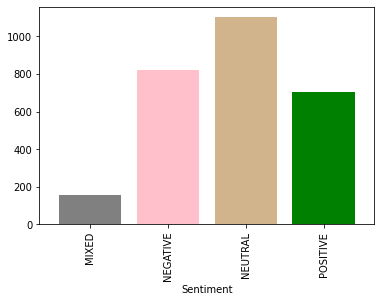

In [127]:
colors = ['Grey', 'Pink', 'Tan', 'Green']
sentiment_results.groupby('Sentiment').size().plot.bar(stacked=True, color = colors, width=0.8);

In [111]:
sentiment_results.groupby('Sentiment').size()/sentiment_results['Sentiment'].count()

Sentiment
MIXED       0.055316
NEGATIVE    0.295618
NEUTRAL     0.396193
POSITIVE    0.252874
dtype: float64

In [297]:
# sentiment_results.groupby('Sentiment').size()
sentiment_results['Sentiment'].count()
# sentiment_results.count()

2784

In [115]:
# sentiment_results.urls.unique()

In [131]:
#Zoom in to individual Videos

# for url in sentiment_results.urls.unique():
#   print(url)

sentiment_results.groupby('urls').size().sort_values(ascending=False)

urls
https://www.youtube.com/watch?v=HMaDV4p1Tho    498
https://www.youtube.com/watch?v=bXbEsKaAdUE    339
https://www.youtube.com/watch?v=dStITCgn73w    327
https://www.youtube.com/watch?v=6ubscmDpZJc    291
https://www.youtube.com/watch?v=Lzw-BLdxiBM    253
https://www.youtube.com/watch?v=5DGwOJXSxqg    237
https://www.youtube.com/watch?v=38_wYKXRvOE    202
https://www.youtube.com/watch?v=LHgwJoQrNtw    169
https://www.youtube.com/watch?v=qiW81dDqILE    121
https://www.youtube.com/watch?v=ayasTHA3MQo     58
https://www.youtube.com/watch?v=wMPy1Fro4Z4     56
https://www.youtube.com/watch?v=8hxxdfprEsY     38
https://www.youtube.com/watch?v=blIMNHEXzks     31
https://www.youtube.com/watch?v=IS5__3Wc_Ps     30
https://www.youtube.com/watch?v=OTMNNcLP1Uo     18
https://www.youtube.com/watch?v=jOJHTn7HeXw     15
https://www.youtube.com/watch?v=mJm4LUNKpqE     14
https://www.youtube.com/watch?v=5ZCuXcooIBg     13
https://www.youtube.com/watch?v=pioJrR3Hfwo     12
https://www.youtube.com/wa

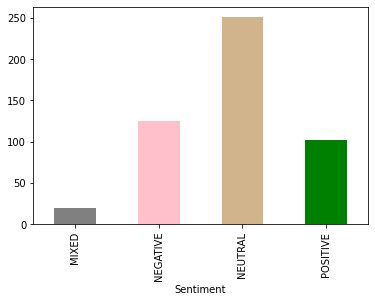

In [132]:
url = "https://www.youtube.com/watch?v=HMaDV4p1Tho"

sentiment_results[sentiment_results['urls']==url].groupby('Sentiment').size().plot.bar(stacked=True, color = colors);

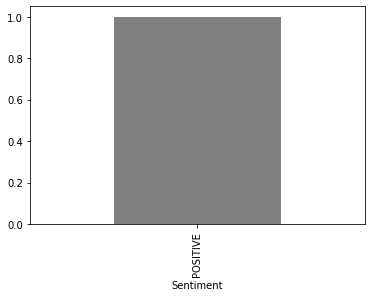

In [133]:
url = "https://www.youtube.com/watch?v=Jn21dyxnlMI"

sentiment_results[sentiment_results['urls']==url].groupby('Sentiment').size().plot.bar(stacked=True, color = colors);

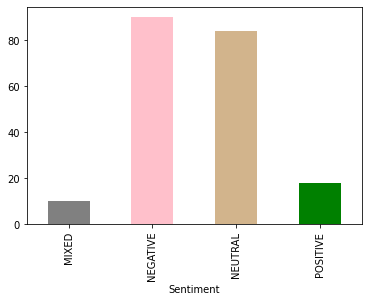

In [134]:
url = "https://www.youtube.com/watch?v=38_wYKXRvOE"

sentiment_results[sentiment_results['urls']==url].groupby('Sentiment').size().plot.bar(stacked=True, color = colors);